# 长短期记忆

## 输入门、遗忘门和输出门

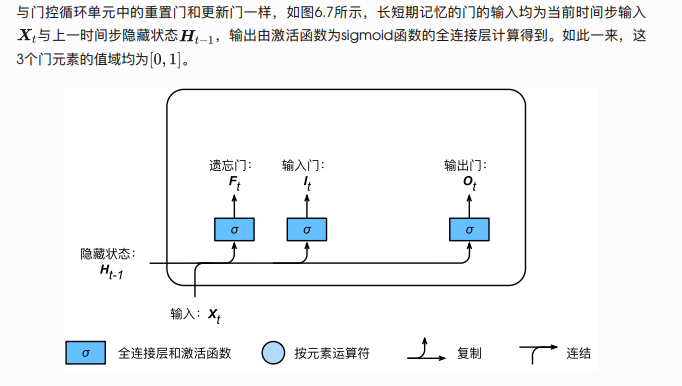
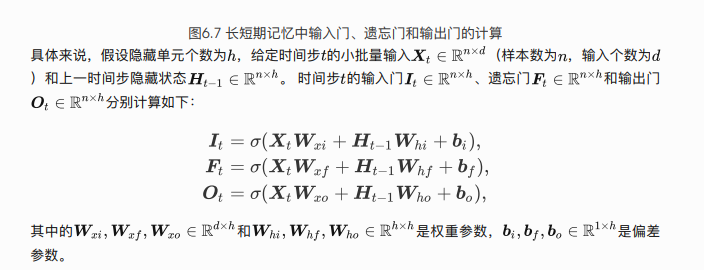

## 候选记忆细胞

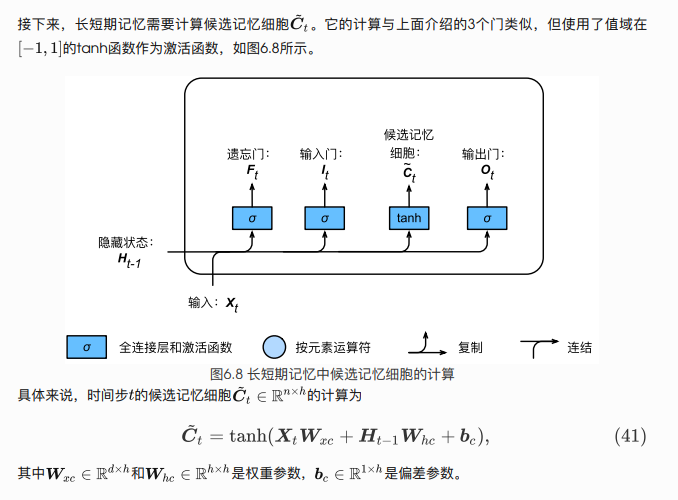

## 记忆细胞

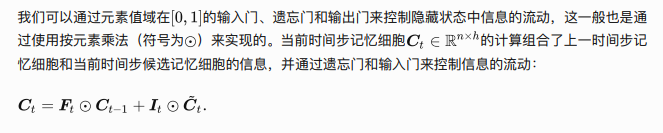
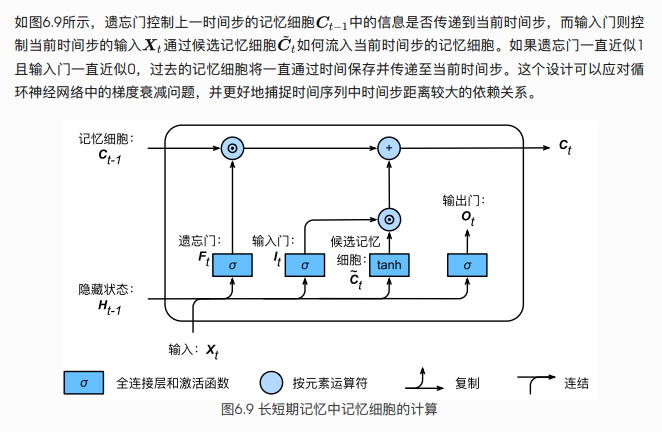

## 隐藏状态

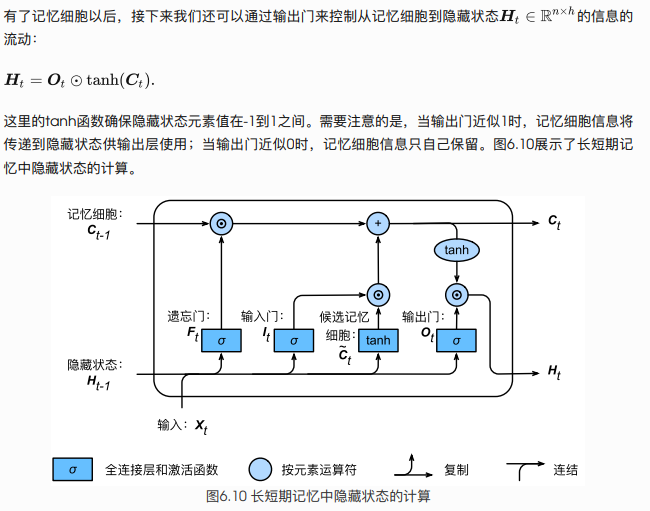

# 读取数据集

In [1]:
import time
import math
import numpy as np
import torch
import random
from torch import nn,optim
import torch.nn.functional as F

import sys

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import zipfile
with zipfile.ZipFile('./Datasets/jaychou_lyrics.txt.zip') as zin:
    with zin.open('jaychou_lyrics.txt') as f:
        corpus_chars=f.read().decode('utf-8')
corpus_chars=corpus_chars.replace('\n',' ').replace('\r',' ')
corpus_chars=corpus_chars[0:10000]
idx_to_char=list(set(corpus_chars))
char_to_idx=dict([(char,i) for i,char in enumerate(idx_to_char)])
vocab_size=len(char_to_idx)
corpus_indices=[char_to_idx[char] for char in corpus_chars]

# 从零开始实现

## 初始化模型参数

In [3]:
num_inputs,num_hiddens,num_outputs=vocab_size,256,vocab_size
print('will use',device)

def get_params():
    def _one(shape):
        ts=torch.tensor(np.random.normal(0,0.01,size=shape),device=device,dtype=torch.float32)
        return torch.nn.Parameter(ts,requires_grad=True)
    def _three():
        return (_one((num_inputs,num_hiddens)),
               _one((num_hiddens,num_hiddens)),
               torch.nn.Parameter(torch.zeros(num_hiddens,device=device,dtype=torch.float32),requires_grad=True))
    W_xi,W_hi,b_i=_three()#输入门参数
    W_xf,W_hf,b_f=_three()#遗忘门参数
    W_xo,W_ho,b_o=_three()#输出门参数
    W_xc,W_hc,b_c=_three()#候选记忆细胞参数
    #输出层参数
    W_hq=_one((num_hiddens,num_outputs))
    b_q=torch.nn.Parameter(torch.zeros(num_outputs,device=device,dtype=torch.float32),requires_grad=True)
    return nn.ParameterList([W_xi,W_hi,b_i,W_xf,W_hf,b_f,W_xo,W_ho,b_o,W_xc,W_hc,b_c,W_hq,b_q])

will use cuda


## 定义模型

In [4]:
def init_lstm_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),
           torch.zeros((batch_size,num_hiddens),device=device))

In [5]:
def lstm(inputs,state,params):
    [W_xi,W_hi,b_i,W_xf,W_hf,b_f,W_xo,W_ho,b_o,W_xc,W_hc,b_c,W_hq,b_q]=params
    (H,C)=state
    outputs=[]
    for X in inputs:
        I=torch.sigmoid(torch.matmul(X,W_xi)+torch.matmul(H,W_hi)+b_i)
        F=torch.sigmoid(torch.matmul(X,W_xf)+torch.matmul(H,W_hf)+b_f)
        O=torch.sigmoid(torch.matmul(X,W_xo)+torch.matmul(H,W_ho)+b_o)
        C_tilda=torch.tanh(torch.matmul(X,W_xc)+torch.matmul(H,W_hc)+b_c)
        C=F*C+I*C_tilda
        H=O*C.tanh()
        Y=torch.matmul(H,W_hq)+b_q
        outputs.append(Y)
    return outputs,(H,C)

## 训练模型并创作歌词

In [6]:
num_epochs,num_steps,batch_size,lr,clipping_theta=160,35,32,1e2,1e-2
pred_period,pred_len,prefixes=40,50,['分开','不分开']

In [7]:
def one_hot(x,n_class,dtype=torch.float32):
    # X shape: (batch), output shape: (batch, n_class)
    x=x.long()
    res=torch.zeros(x.shape[0],n_class,dtype=dtype,device=x.device)
    res.scatter_(1,x.view(-1,1),1)
    return res
def to_onehot(X,n_class):
    # X shape: (batch, seq_len), output: seq_len elements of (batch,n_class)
    return [one_hot(X[:,i],n_class) for i in range(X.shape[1])]

In [8]:
def data_iter_consecutive(corpus_indices,batch_size,num_steps,device=None):
    if device is None:
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    corpus_indices=torch.tensor(corpus_indices,dtype=torch.float32,device=device)
    data_len=len(corpus_indices)
    batch_len=data_len//batch_size
    indices=corpus_indices[0:batch_size*batch_len].view(batch_size,batch_len)
    epoch_size=(batch_len-1)//num_steps
    for i in range(epoch_size):
        i=i*num_steps
        X=indices[:,i:i+num_steps]
        Y=indices[:,i+1:i+num_steps+1]
        yield X,Y

In [9]:
def grad_clipping(params,theta,device):
    norm=torch.tensor([0.0],device=device)
    for param in params:
        norm+=(param.grad.data**2).sum()
    norm=norm.sqrt().item()
    if norm>theta:
        for param in params:
            param.grad.data*=(theta/norm)

In [10]:
def sgd(params,lr,batch_size):
    for param in params:
        param.data-=lr*param.grad/batch_size

In [11]:
def predict_rnn(prefix,num_chars,rnn,params,init_rnn_state,num_hiddens,vocab_size,device,idx_to_char,char_to_idx):
    state=init_rnn_state(1,num_hiddens,device)
    output=[char_to_idx[prefix[0]]]
    for t in range(num_chars+len(prefix)-1):
        X=to_onehot(torch.tensor([[output[-1]]],device=device),vocab_size)
        (Y,state)=rnn(X,state,params)
        if t<len(prefix)-1:
            output.append(char_to_idx[prefix[t+1]])
        else:
            output.append(int(Y[0].argmax(dim=1).item()))
    return ''.join([idx_to_char[i] for i in output])

In [12]:
def train_and_predict_rnn(rnn,get_params,init_rnn_state,num_hiddens,vocab_size,device,corpus_indices,idx_to_char,char_to_idx,is_random_iter,num_epochs,num_steps,lr,clipping_theta,batch_size,pred_period,pred_len,prefixes):
    if is_random_iter:
        data_iter_fn=data_iter_random
    else:
        data_iter_fn=data_iter_consecutive
    params=get_params()
    loss=nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        if not is_random_iter:# 如使⽤相邻采样，在epoch开始时初始化隐藏状态
            state=init_rnn_state(batch_size,num_hiddens,device)
        l_sum,n,start=0.0,0,time.time()
        data_iter=data_iter_fn(corpus_indices,batch_size,num_steps,device)
        for X,Y in data_iter:
            if is_random_iter:# 如使⽤随机采样，在每个⼩批量更新前初始化隐藏状态
                state=init_rnn_state(batch_size,num_hiddens,device)
            else:
                # 否则需要使⽤detach函数从计算图分离隐藏状态, 这是为了
                # 使模型参数的梯度计算只依赖⼀次迭代读取的⼩批量序列(防⽌梯度计算开销太⼤）
                for s in state:
                    s.detach_()
            inputs=to_onehot(X,vocab_size)
            (outputs,state)=rnn(inputs,state,params)
            outputs=torch.cat(outputs,dim=0)
            y=torch.transpose(Y,0,1).contiguous().view(-1)
            l=loss(outputs,y.long())
            if params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            grad_clipping(params,clipping_theta,device)
            sgd(params,lr,1)
            l_sum+=l.item()*y.shape[0]
            n+=y.shape[0]
        if (epoch+1)%pred_period==0:
            print('epoch %d,perplexity %f,time %.2f sec'%(epoch+1,math.exp(l_sum/n),time.time()-start))
            for prefix in prefixes:
                print('-',predict_rnn(prefix,pred_len,rnn,params,init_rnn_state,num_hiddens,vocab_size,device,idx_to_char,char_to_idx))

In [14]:
train_and_predict_rnn(lstm,get_params,init_lstm_state,num_hiddens,vocab_size,device,corpus_indices,idx_to_char,char_to_idx,False,num_epochs,num_steps,lr,clipping_theta,batch_size,pred_period,pred_len,prefixes)

epoch 40,perplexity 206.070966,time 0.94 sec
- 分开 我不的我 我不的我 我不的我 我不的我 我不的我 我不的我 我不的我 我不的我 我不的我 我不的我
- 不分开 我不的我 我不的 我不的 我不的 我不的 我不的 我不的 我不的 我不的 我不的 我不的 我不的 
epoch 80,perplexity 65.200358,time 0.92 sec
- 分开 我想你你的你  有有你的你我 想想你你的爱  有有你 我想要这我 我不要你不着 我不要你不样 我不
- 不分开 我想你你的爱  有有你的你我 想想你你的爱  有有你 我想要这我 我不要你不着 我不要你不样 我不
epoch 120,perplexity 15.124884,time 0.92 sec
- 分开 我想你这生堡 快天  又给我的太着 一话后 一直我 说你怎么我么  有有你 我给了这节奏 后知后觉
- 不分开 我说你 你我我 说你 是怎么 你么么 我想了这牵着 有你么 是我了你起着 有话去么医药箱 我想就这
epoch 160,perplexity 4.089137,time 0.92 sec
- 分开 一个我 不子是人人江南等我 泪不休 语沉默娘子 娘子却依旧每日 折一枝杨柳 你在那里 在小村外的溪
- 不分开 你是我 你子我 我不开 是不是 是是是空留留 一色在看着落 它攻了篮我球 相亮了我球球 我说了我 


# 简洁实现

In [15]:
class RNNModel(nn.Module):
    def __init__(self,rnn_layer,vocab_size):
        super(RNNModel,self).__init__()
        self.rnn=rnn_layer
        self.hidden_size=rnn_layer.hidden_size*(2 if rnn_layer.bidirectional else 1)
        self.vocab_size=vocab_size
        self.dense=nn.Linear(self.hidden_size,vocab_size)
        self.state=None
    def forward(self,inputs,state):
        #inputs: (batch, seq_len)
        X=to_onehot(inputs,self.vocab_size)
        Y,self.state=self.rnn(torch.stack(X),state)
        output=self.dense(Y.view(-1,Y.shape[-1]))
        return output,self.state      

In [16]:
def predict_rnn_pytorch(prefix,num_chars,model,vocab_size,device,idx_to_char,char_to_idx):
    state=None
    output=[char_to_idx[prefix[0]]]
    for t in range(num_chars+len(prefix)-1):
        X=torch.tensor([output[-1]],device=device).view(1,1)
        if state is not None:
            if isinstance(state,tuple):
                state=(state[0].to(device),state[1].to(device))
            else:
                state=state.to(device)
        (Y,state)=model(X,state)
        if t<len(prefix)-1:
            output.append(char_to_idx[prefix[t+1]])
        else:
            output.append(int(Y.argmax(dim=1).item()))
    return ''.join([idx_to_char[i] for i in output])

In [17]:
def train_and_predict_rnn_pytorch(model,num_hiddens,vocab_size,device,corpus_indices,idx_to_char,char_to_idx,num_epochs,num_steps,lr,clipping_theta,batch_size,pred_period,pred_len,prefixes):
    loss=nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    model.to(device)
    state=None
    for epoch in range(num_epochs):
        l_sum,n,start=0.0,0,time.time()
        data_iter=data_iter_consecutive(corpus_indices,batch_size,num_steps,device)
        for X,Y in data_iter:
            if state is not None:
                if isinstance(state,tuple):# LSTM, state:(h, c)
                    state=(state[0].detach(),state[1].detach())
                else:
                    state=state.detach()
            (output,state)=model(X,state)
            y=torch.transpose(Y,0,1).contiguous().view(-1)
            l=loss(output,y.long())
            optimizer.zero_grad()
            l.backward()
            grad_clipping(model.parameters(),clipping_theta,device)
            optimizer.step()
            l_sum+=l.item()*y.shape[0]
            n+=y.shape[0]
        try:
            perplexity=math.exp(l_sum/n)
        except OverflowError:
            perplexity=float('inf')
        if (epoch+1)%pred_period==0:
            print('epoch %d,perplexity %f,time %.2f sec '%(epoch+1,perplexity,time.time()-start))
            for prefixe in prefixes:
                print(' -',predict_rnn_pytorch(prefixe,pred_len,model,vocab_size,device,idx_to_char,char_to_idx))

In [18]:
lr=1e-2
lstm_layer=nn.LSTM(input_size=vocab_size,hidden_size=num_hiddens)
model=RNNModel(lstm_layer,vocab_size)
train_and_predict_rnn_pytorch(model,num_hiddens,vocab_size,device,corpus_indices,idx_to_char,char_to_idx,num_epochs,num_steps,lr,clipping_theta,batch_size,pred_period,pred_len,prefixes)

epoch 40,perplexity 1.021201,time 0.37 sec 
 - 分开始移动 回到当初爱你的时空 停格内容不忠 所有回忆对着我进攻 我的伤口被你拆封 誓言太沉重泪被纵容 
 - 不分开始移动 回到当初爱你的时空 停格内容不忠 所有回忆对着我进攻 我的伤口被你拆封 誓言太沉重泪被纵容 
epoch 80,perplexity 1.012196,time 0.37 sec 
 - 分开始移动 回到当初爱你的时空 停格内容不忠 所有回忆对着我进攻 我的伤口被你拆封 誓言太沉重泪被纵容 
 - 不分开始移动 回到当初爱你的时空 停格内容不忠 所有回忆对着我进攻 我的伤口被你拆封 誓言太沉重泪被纵容 
epoch 120,perplexity 1.019007,time 0.38 sec 
 - 分开始移动 回到当初爱你的时空 停格内容不忠 所有回忆对着我进攻 我的伤口被你拆封 誓言太沉重泪被纵容 
 - 不分开 我该好好生活 不知不觉 你已经离开我 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我
epoch 160,perplexity 1.007631,time 0.37 sec 
 - 分开始移动 在小村外的溪边河口默默等著我 娘子依旧每日折一枝杨柳 你在那里 在小村外的溪边 默默等待 娘
 - 不分开 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生活 不知不觉 你已经离开我
